In [1]:
from IPython.display import clear_output

In [2]:
%pip install torch torchvision torchsummary
%pip install numpy
%pip install matplotlib

clear_output()

In [3]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## Contents

Today we'll attempt to create a number image generator through auto encoders. Here's the technique

1. The model has 2 parts, an encoder and a decoder
2. The encoder takes number image (mnist) and converts it into an embedding/encoding of specified size (output of encoder last layer). by passing it through multiple linear layers.
3. The decoder then takes that encoding and attempts to re-create the original image
4. During training, our cost function is the difference between generated image and original image. we'll use MSE Loss for this
5. Once the training is complete, we'll create our own embeddings of specified size ourselves and run it through the decoder to generate images


Note: In this notebook we'll limit ourselves to Linear Layers or BatchNorm's only (and activations). Which means NO CNN, attention, or anything fancier. For this reason, the performance might be questionable. What we wanna see is the model trying to capture the pattern?

You need to know:

1. **pytorch** (for impelementation)
2. a bit of **torch dataloaders and datasets** (not necessary but helps understanding how we're loading data)
3. A little bit of **matplotlib** (for result and training trajectory visualization)

In [5]:
batch_size = 64

train_transforms = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])

train_data = MNIST(root='./datasets', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [8]:
class AutoEncoderGenerator(nn.Module):

  def __init__(self, dim_z):
    super().__init__()
    self.Encoder = nn.Sequential(

        nn.Linear(28*28, 1024),
        nn.LeakyReLU(),
        nn.BatchNorm1d(1024),

        nn.Linear(1024, 512),
        nn.LeakyReLU(),
        nn.BatchNorm1d(512),

        nn.Linear(512, 256),
        nn.LeakyReLU(),

        nn.Linear(256, dim_z),
        nn.Tanh(),
      )


    self.Decoder = nn.Sequential(
        nn.Linear(dim_z, 256),
        nn.LeakyReLU(),

        nn.Linear(256, 512),
        nn.LeakyReLU(),

        nn.Linear(512, 1024),
        nn.LeakyReLU(),

        nn.Linear(1024, 28*28),
        nn.Sigmoid()
      )

  def forward(self, x):

    original_shape = x.shape
    x = torch.flatten(x, start_dim=1)

    z = self.Encoder(x)
    x = self.Decoder(z)

    x = x.view(original_shape)

    return x


In [10]:
dim_z = 128
model = AutoEncoderGenerator(dim_z=dim_z)

In [11]:
summary(model, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         803,840
         LeakyReLU-2                 [-1, 1024]               0
       BatchNorm1d-3                 [-1, 1024]           2,048
            Linear-4                  [-1, 512]         524,800
         LeakyReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                  [-1, 256]         131,328
         LeakyReLU-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
             Tanh-10                  [-1, 128]               0
           Linear-11                  [-1, 256]          33,024
        LeakyReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 512]         131,584
        LeakyReLU-14                  [

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

num_epochs = 20
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [13]:
train_losses = []

for i in range(num_epochs):

  epoch_weighted_loss = 0
  for (X, _) in train_loader:

    X = X.to(device)

    Xhat = model(X)  # Xhat because we're trying to have the model regenerate what's fed to it (X)

    optimizer.zero_grad()
    loss = criterion(Xhat, X)
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += loss.item()*len(X)

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

  print(f'epoch {i}/{num_epochs}, loss = {epoch_loss}')

  train_losses.append(epoch_loss)

epoch 0/20, loss = 0.06086590871612231
epoch 1/20, loss = 0.034609035036961236
epoch 2/20, loss = 0.028115130572517712
epoch 3/20, loss = 0.02508573321402073
epoch 4/20, loss = 0.023217721276481945
epoch 5/20, loss = 0.021876786430676778
epoch 6/20, loss = 0.020544521500666935
epoch 7/20, loss = 0.019413635801275572
epoch 8/20, loss = 0.01847025869290034
epoch 9/20, loss = 0.017652810936172804
epoch 10/20, loss = 0.016894362011551856
epoch 11/20, loss = 0.016269306501746177
epoch 12/20, loss = 0.015687114692727724
epoch 13/20, loss = 0.015175317338109017
epoch 14/20, loss = 0.014742704956730206
epoch 15/20, loss = 0.01437402638544639
epoch 16/20, loss = 0.013952443948388099
epoch 17/20, loss = 0.013631278737386067
epoch 18/20, loss = 0.013268639122943083
epoch 19/20, loss = 0.012992325617869695


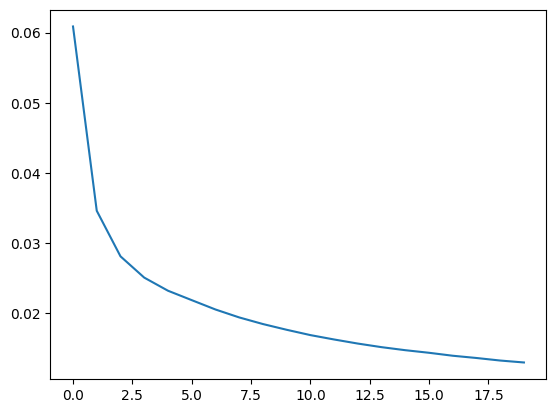

In [14]:
plt.plot(train_losses)

In [16]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im, cmap="gray")
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

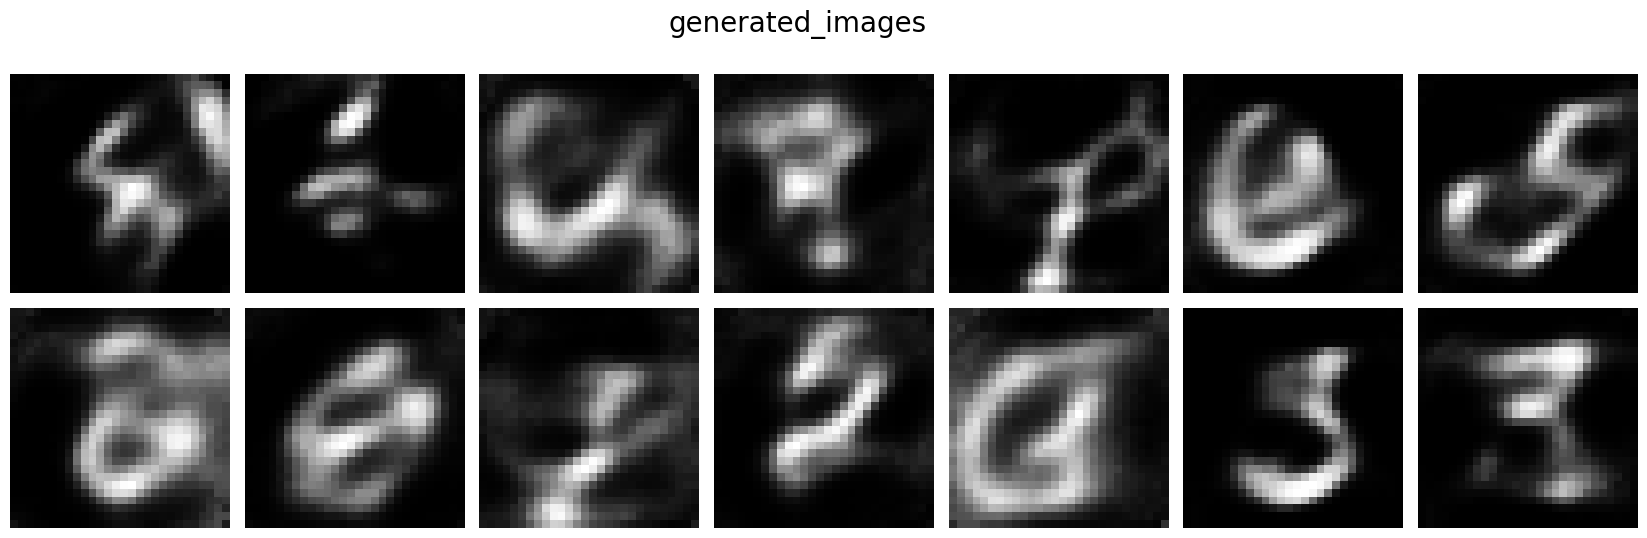

In [19]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder

rows, cols = 2, 7
sample_encodings = (torch.rand(rows*cols, dim_z).to(device) - 0.5) * 2 # encoding space: [-1,1)
with torch.no_grad():
  generations = model.Decoder(sample_encodings).cpu()
  generations = generations.reshape(-1, 28, 28, 1)
display_image_grid(generations, rows, cols, "generated_images")

The images aren't too fancy but we can see it's trying to learn.
In a few images we can also guess the number it's trying to generate